# MA Strategy with Regime/Trend Detection Filter Using the ADX
Average Directional Movement Index (ADX)

In [ ]:
# auto reload
%load_ext autoreload
%autoreload 2

# Imports
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

import core_metrics, file_exports

In [2]:
def ma_regime_detection(inv_amt, prices_df, short_ma, long_ma, 
                adx_cutoff,
                transaction_costs=0.001,  # as a percent
                slippage=0.0005,  # as a percent
                  # Changed parameter name
                ):
    df = prices_df.copy()
    df = df.drop(columns=['Dividends', "Capital Gains", "Stock Splits"], errors="ignore") 

    df["MA_short"] = df["Close"].rolling(window=short_ma).mean()
    df["MA_long"] = df["Close"].rolling(window=long_ma).mean()

    # find ADX
    Window = 14
    df['+DM'] = np.where(
      (df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
      np.maximum(df['High'] - df['High'].shift(1), 0),
      0
    )
    df['-DM'] = np.where(
        (df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
        np.maximum(df['Low'].shift(1) - df['Low'], 0),
        0
    )

    # ATR - for finding ADX
    df['TR'] = np.maximum(
    np.maximum(
        df['High'] - df['Low'],
        np.abs(df['High'] - df['Close'].shift(1))  
    ),
    np.abs(df['Close'].shift(1) - df['Low'])
    )
    df['ATR'] = df['TR'].rolling(window=Window).mean()
    
    df['+DM_EMA'] = df['+DM'].ewm(span=Window, adjust=False).mean()
    df['-DM_EMA'] = df['-DM'].ewm(span=Window, adjust=False).mean()

    df['+DI'] = 100 * df['+DM_EMA'] / df['ATR']
    df['-DI'] = 100 * df['-DM_EMA'] / df['ATR']
    df['DX'] = np.abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI']) * 100
    df['ADX'] = df['DX'].ewm(span=Window, adjust=False).mean()

    # Calculate threshold from data (renamed variable)
    df['trending'] = df['ADX'] > adx_cutoff

    # signal for trading
    df["signal"] = 0
    df.loc[
        (df["MA_short"] > df["MA_long"]) & 
        (df['trending']) &  
        (df['ATR'].notna()),  # Ensure ATR is valid
        "signal"
    ] = 1
    
    # cost calculations
    total_cost = transaction_costs + slippage
    df["position"] = df["signal"].diff()
    df["trade_cost"] = 0.0
    df.loc[df['position'] != 0, 'trade_cost'] = total_cost

    # calculate returns
    df['market_ret'] = df['Close'].pct_change()
    df['strategy_ret'] = df['market_ret'] * df['signal'].shift(1)
    df['strategy_ret_net'] = df['strategy_ret'] - df['trade_cost']
    
    # Market portfolio - buy at beginning, hold for the whole time
    df['market_ret_net'] = df['market_ret'].copy()
    df.loc[df.index[0], 'market_ret_net'] = df.loc[df.index[0], 'market_ret'] - total_cost

    # Calculate cumulative returns
    df['cumulative_market'] = (1 + df['market_ret_net']).cumprod()
    df['cumulative_strategy'] = (1 + df['strategy_ret_net']).cumprod()
    
    # Portfolio value
    df['portfolio_value'] = inv_amt * df['cumulative_strategy']
    df['market_portfolio_value'] = inv_amt * df['cumulative_market']  # Add this for consistency metrics

    df = df.set_index("Date", inplace=False, drop=True, append=False)
   
    df.index = pd.to_datetime(df.index).tz_localize(None).normalize()

    return df

In [3]:
# running the strategy
# constants
investment_amount = 10000
test_data = pd.read_csv("../data/processed/training_data_70.csv")
short_ma = 20
long_ma = 50
adx_cutoff = 25
result = ma_regime_detection(investment_amount, test_data, short_ma, long_ma, adx_cutoff, transaction_costs=0.001, slippage=0.0005)

In [18]:
result.tail()

,Open,High,Low,Close,Volume,MA_short,MA_long,+DM,-DM,TR,...,position,trade_cost,market_ret,strategy_ret,strategy_ret_net,market_ret_net,cumulative_market,cumulative_strategy,portfolio_value,market_portfolio_value
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-01,374.407182,378.114169,371.691250,377.771118,78740100,395.322708,381.919368,0.000000,4.764860,6.422919,...,0.0,0.0,0.003138,0.003138,0.003138,0.003138,2.214503,1.233968,12339.683053,22145.026369
2022-09-02,381.449562,382.669345,371.967630,373.787781,99632100,394.311145,382.189626,4.555177,0.000000,10.701716,...,0.0,0.0,-0.010544,-0.010544,-0.010544,-0.010544,2.191152,1.220957,12209.569557,21911.522251
2022-09-06,374.635914,375.579332,370.147495,372.377411,76637400,393.251935,382.202587,0.000000,1.820134,5.431836,...,0.0,0.0,-0.003773,-0.003773,-0.003773,-0.003773,2.182885,1.216350,12163.500611,21828.846058
2022-09-07,372.062841,379.838970,371.843679,379.067078,70964200,392.605350,382.377738,4.259638,0.000000,7.995291,...,0.0,0.0,0.017965,0.017965,0.017965,0.017965,2.222100,1.238201,12382.014847,22220.995800
2022-09-08,376.789585,382.002231,375.579312,381.544830,80821700,391.670975,382.753773,2.163261,0.000000,6.422919,...,0.0,0.0,0.006536,0.006536,0.006536,0.006536,2.236624,1.246295,12462.949258,22366.242209


In [7]:
# export as csv in the data file
csv_name = "ma_trend_detection.csv"
output_folder = "../data/strategy_results/"

from file_exports import export_file
export_file(csv_name, output_folder, result)

Exported data as file ../data/strategy_results/ma_trend_detection.csv successfully.


In [19]:
# prelim test on final strategy portfolio value given varying threshold levels
thresholds = [10, 15, 20, 25, 30, 40]
for t in thresholds:
    res = ma_regime_detection(investment_amount, test_data, short_ma, long_ma, t, transaction_costs=0.001, slippage=0.0005)
    print(f"ADX cutoff = {t}, final value = {res['portfolio_value'].iloc[-1]}")

ADX cutoff = 10, final value = 17372.876772805223
ADX cutoff = 15, final value = 17275.874816034153
ADX cutoff = 20, final value = 13227.366421166462
ADX cutoff = 25, final value = 12462.949257950282
ADX cutoff = 30, final value = 11165.626053322796
ADX cutoff = 40, final value = 10215.776085734773


## Core Performance Metrics
To evaluate the basline strategy, we will perform the following tests.


### 1. Profit & Loss Metrics
Let's examine the returns and P&L of the strategy and market portfolios, considering transaction cost and slippage amounts as defined above.

Final portfolio value: 12462.949257950282 on 2022-09-08 00:00:00
Strategy returned 24.62949257950282% from 2015-01-02 00:00:00 to 2022-09-08 00:00:00
Market returned 123.66242209135079 from 2015-01-02 00:00:00 to 2022-09-08 00:00:00

Annualized across 7.6824 years: 
MA Strategy with Trend Detection returned 2.9074% per year
Buy & Hold the market returned 11.0467% per year


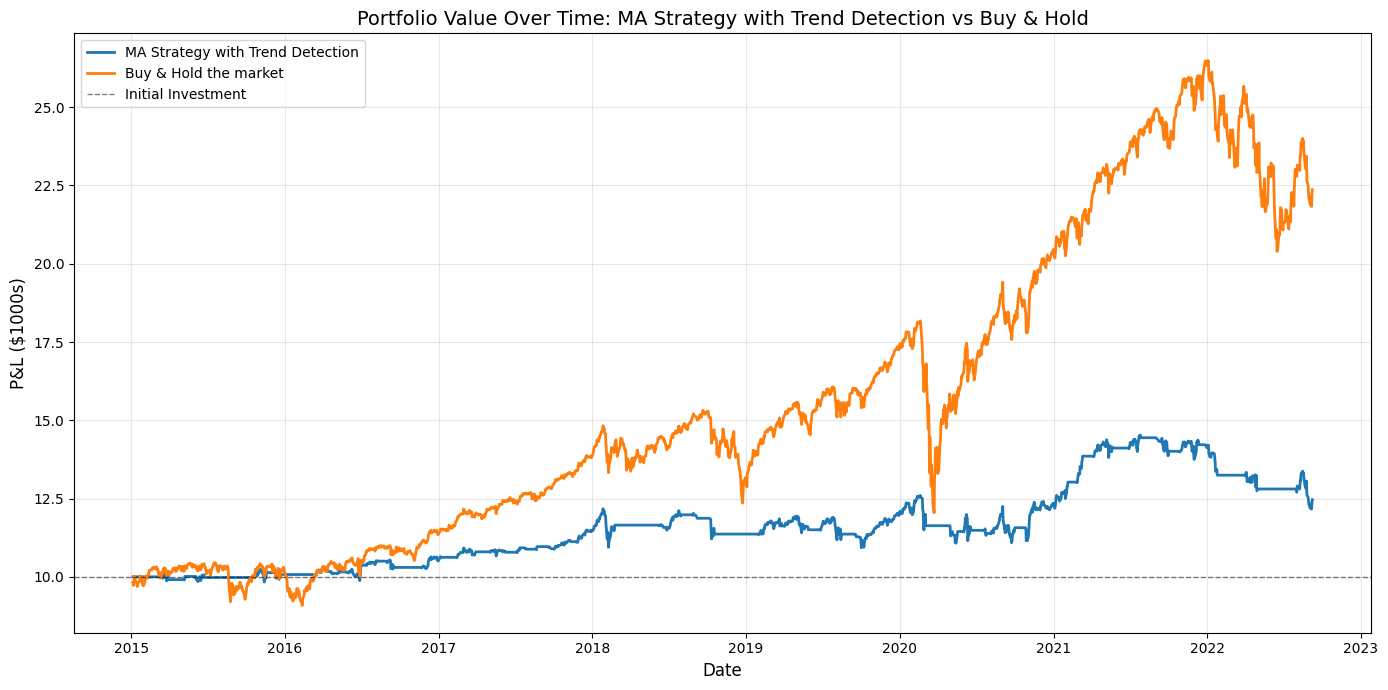

In [20]:
from core_metrics import pnl

graph_title = 'Portfolio Value Over Time: MA Strategy with Trend Detection vs Buy & Hold'
strategy_name = "MA Strategy with Trend Detection"
benchmark_name = "Buy & Hold the market"

result, strategy_annual_return, market_annual_return = pnl(result, investment_amount, strategy_name, benchmark_name, graph_title)

### 2. Performance Ratios

In [21]:
from core_metrics import performance_ratios

perf_ratios = performance_ratios(result)

print("WITHOUT transaction costs...")
print(f"Sharpe Ratio: {perf_ratios['sharpe ratio']}")
print(f"Information Ratio: {perf_ratios['information ratio']}")
print(f"Sortino Ratio: {perf_ratios['sortino ratio']} \n")

print("WITH transaction costs...")
print(f"Sharpe Ratio: {perf_ratios['sharpe with costs']}")
print(f"Information Ratios: {perf_ratios['information ratio with costs']}")
print(f"Sortino Ratio: {perf_ratios['sortino ratio with costs']}")


WITHOUT transaction costs...
Sharpe Ratio: 0.34888680377395387
Information Ratio: 10.25371509021513
Sortino Ratio: 5.002787647801159 

WITH transaction costs...
Sharpe Ratio: 0.09219946812837998
Information Ratios: 10.240909782033382
Sortino Ratio: 1.3176648988832589


In [22]:
from core_metrics import risk_metrics

risks = risk_metrics(result)
print(f"Max Drawdown: {(100 * risks['max_drawdown']):.2f}%")
print(f"Average Drawdown: {(100 * risks['avg_drawdown']):.2f}%")
print(f"Max Drawdown Duration: {(risks['max_dd_duration']):.2f} days")
print(f"Average Drawdown Duration: {(risks['avg_dd_duration']):.2f} days")
print(f"Volatility: {(100 * risks['volatility']):.2f}%")

Max Drawdown: -16.29%
Average Drawdown: -3.50%
Max Drawdown Duration: 492.00 days
Average Drawdown Duration: 28.95 days
Volatility: 9.76%


### 4. Trade Statistics

In [23]:
from core_metrics import trade_statistics

trade_stats = trade_statistics(result)
print(f"Total Number of Trades: {trade_stats['num_trades']}")
print(f"Average Holding Periods: {trade_stats['avg_holding_period']}")
print(f"Win Rate: {trade_stats['win_rate']}")
print(f"Win-Loss Ratio: {trade_stats['win_loss_ratio']}")
print(f"Profit Factor (gross profit/gross loss): {trade_stats['profit_factor']}")


Total Number of Trades: 123
Average Holding Periods: 20.24590163934426
Win Rate: 0.5737704918032787
Win-Loss Ratio: inf
Profit Factor (gross profit/gross loss): 2.232042658335981


### 5. Strategy Beta to Benchmark

In [24]:
from core_metrics import find_alpha, calmar_ratio, find_beta

beta = find_beta(result, result.index[0], result.index[-1])
print(f'Beta: {beta}')
alpha = find_alpha(result, strategy_annual_return, market_annual_return)
print(f'Alpha: {alpha}')
calmar = calmar_ratio(strategy_annual_return, risks['max_drawdown'])
print(f'Calmar Ratio: {calmar:.2f}')

Beta: 0.28377633126448193
Alpha: -0.016649121211935514
Calmar Ratio: 0.18


### 5. Consistency of Returns

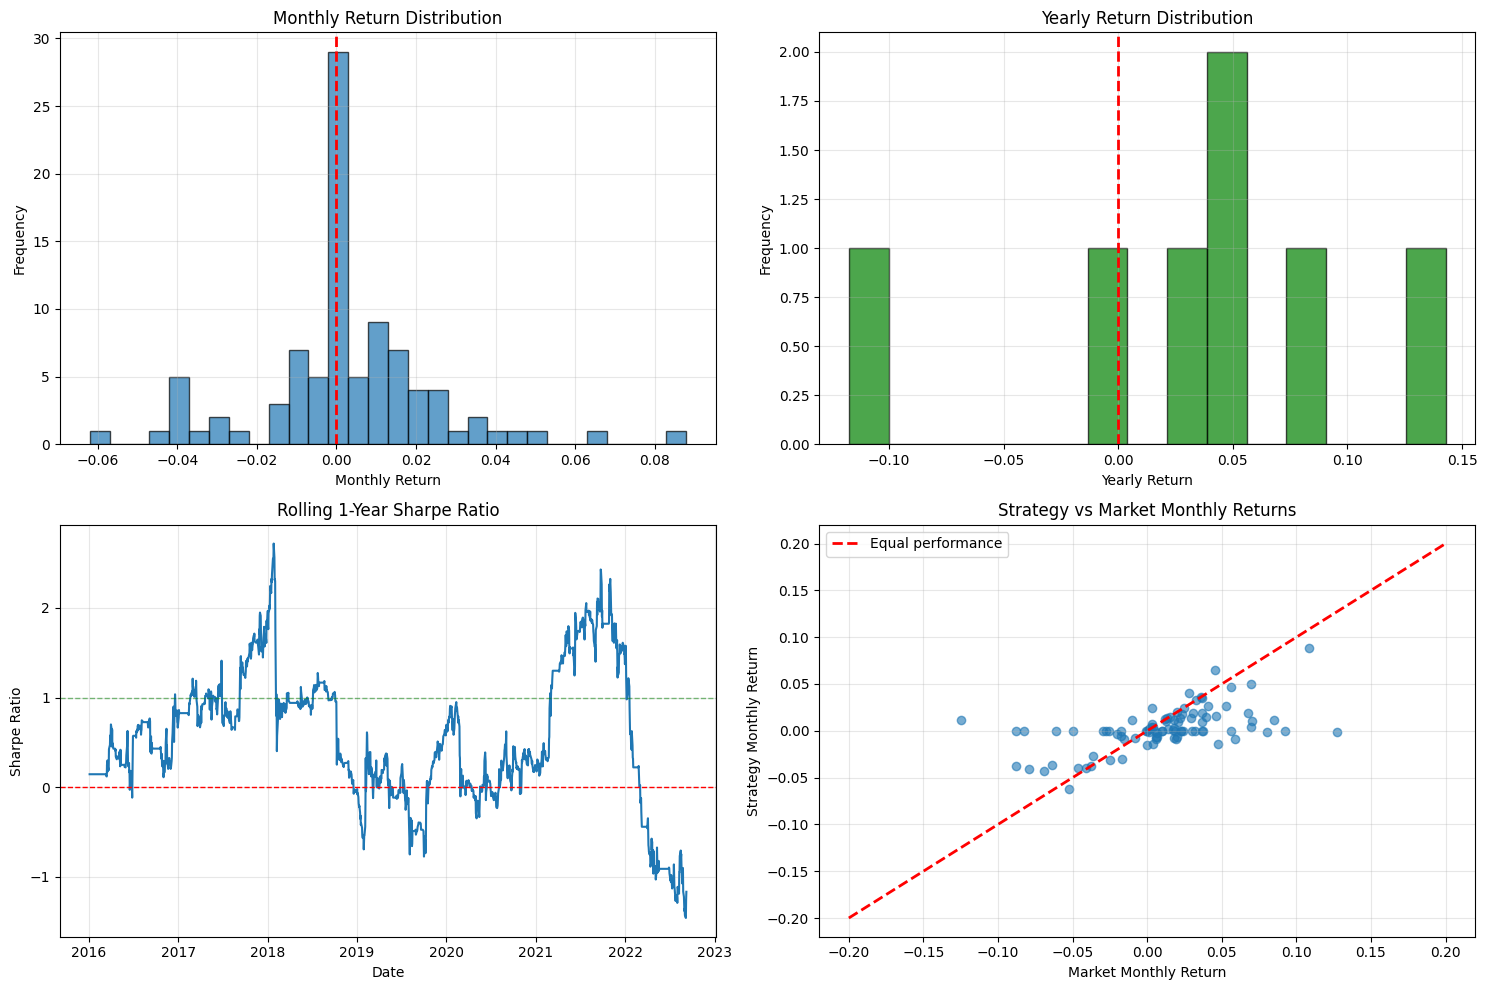

Percentage of Positive Months: 43.01%
Average Monthly Return: 0.26%
Median Monthly Return: 0.00%
Standard Deviation of Monthly Returns: 2.26%
Percentage of Positive Years: 62.50%
Average Yearly Return: 3.38%
Median Yearly Return: 4.28%


In [25]:
from core_metrics import consistency

window = 252 # trading days (for rolling sharpe)
consistency = consistency(result, window)

print(f"Percentage of Positive Months: {consistency['pct_positive_months']:.2%}")
print(f"Average Monthly Return: {consistency['avg_monthly_return']:.2%}")
print(f"Median Monthly Return: {consistency['median_monthly_return']:.2%}")
print(f"Standard Deviation of Monthly Returns: {consistency['std_monthly_return']:.2%}")

print(f"Percentage of Positive Years: {consistency['pct_positive_years']:.2%}")
print(f"Average Yearly Return: {consistency['avg_yearly_return']:.2%}")
print(f"Median Yearly Return: {consistency['median_yearly_return']:.2%}")


### 6. Sensitivity of Returns to Transaction Costs

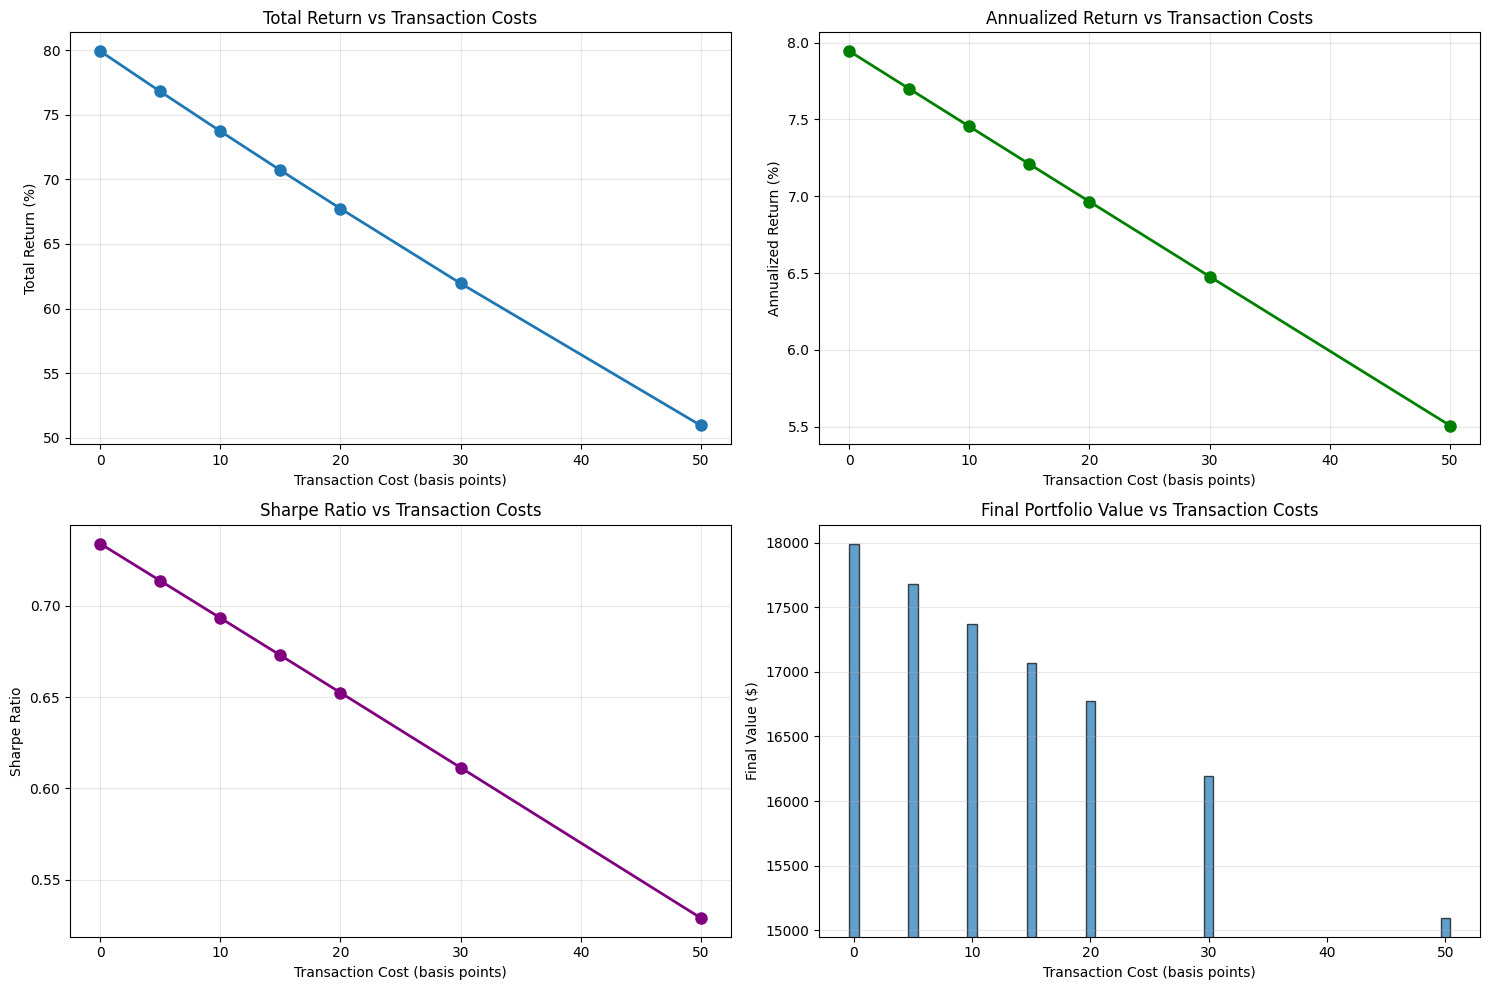

Transaction Cost Sensitivity Analysis
 cost_bps  cost_pct  total_return  annualized_return  sharpe_ratio  final_value
      0.0      0.00      0.799238           0.079454      0.733967 17992.384772
      5.0      0.05      0.768000           0.076996      0.713652 17679.995044
     10.0      0.10      0.737288           0.074542      0.693286 17372.876773
     15.0      0.15      0.707094           0.072093      0.672872 17070.943578
     20.0      0.20      0.677411           0.069648      0.652416 16774.110453
     30.0      0.30      0.619541           0.064771      0.611401 16195.411122
     50.0      0.50      0.509562           0.055068      0.529112 15095.620529


Strategy remains profitable at all tested cost levels


In [ ]:
from core_metrics import sensitivity

prices_data = pd.read_csv("../data/processed/training_data_70.csv")

def ma_volatility_filter_helper(investment_amount, test_data, short_ma, long_ma, transaction_costs=0.001, slippage=0.0005):
    res = ma_regime_detection(investment_amount, test_data, short_ma, long_ma, threshold, transaction_costs, slippage)
    return res
df = sensitivity(ma_volatility_filter_helper, investment_amount, prices_data, short_ma, long_ma)